# $\nu$DoBe event generation
This notebook generates the 3-momentum distributions of both decay electrons in a $^{136}$Xe neutrinoless double beta decay event, according to different Low-Energy Effective Field Theory (LEFT) models implemented in $\nu$DoBe. The electron kinematics output of the events is written to an ASCII file, for its further processing within the nexus detector simulation framework.  

### Imports

In [1]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

### Configuration

In [2]:
#Set up a LEFT model

#WC = {"m_bb" : 0.1e-9,
#      "VR(6)" : 3e-7
#     }

#model = LEFT(WC, method = "SM",
#             name  = r"$m_{\beta\beta} + C_\mathrm{VR}^{(6)}$")

WC = {"VL(6)" : 1.e-6} 
model = LEFT(WC, method = "SM", name="VL(6)")
outfile = '../generation/generation_nudobe_test.txt'
imagefile = 'Model_test.png'

# Model 1: mass mechanism (dim 3)
#WC = {"m_bb" : 0.1e-9} # GeV units: 0.1e-9 GeV = 0.1 eV
#model = LEFT(WC, name = r"$m_{\beta\beta}$", method = "SM")
#outfile = '../generation/generation_nudobe_mbb.txt'
#imagefile = 'Model_mbb.png'

# Model 2: SL(6) (dim 6)
#WC = {"SL(6)" : 1e-6} # dimensionless
#model = LEFT(WC, name = r"SL(6)", method = "SM")
#outfile = '../generation/generation_nudobe_SL6.txt'
#imagefile = 'Model_SL6.png'

# Model 3: SR(6) (dim 6)
#WC = {"SR(6)" : 1e-6} # dimensionless
#model = LEFT(WC, name = r"SR(6)", method = "SM")
#outfile = '../generation/generation_nudobe_SR6.txt'
#imagefile = 'Model_SR6.png'

# Model 4: T(6) (dim 6)
#WC = {"T(6)" : 1e-6} # dimensionless
#model = LEFT(WC, name = r"T(6)", method = "SM")
#outfile = '../generation/generation_nudobe_T6.txt'
#imagefile = 'Model_T6.png'

# Model 5: VL(6) (dim 6)
#WC = {"VL(6)" : 1e-6} # dimensionless
#model = LEFT(WC, name = r"VL(6)", method = "SM")
#outfile = '../generation/generation_nudobe_VL6.txt'
#imagefile = 'Model_VL6.png'

# Model 6: VR(6) (dim 6)
#WC = {"VR(6)" : 1e-6} # dimensionless
#model = LEFT(WC, name = r"VR(6)", method = "SM")
#outfile = '../generation/generation_nudobe_VR6.txt'
#imagefile = 'Model_VR6.png'

nbins = 100
eps = 1e-5 #avoid poles
nevts = 100000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units

EFT.LEFT_WCs

{'m_bb': 0,
 'SL(6)': 0,
 'SR(6)': 0,
 'T(6)': 0,
 'VL(6)': 0,
 'VR(6)': 0,
 'VL(7)': 0,
 'VR(7)': 0,
 '1L(9)': 0,
 '1R(9)': 0,
 '1L(9)prime': 0,
 '1R(9)prime': 0,
 '2L(9)': 0,
 '2R(9)': 0,
 '2L(9)prime': 0,
 '2R(9)prime': 0,
 '3L(9)': 0,
 '3R(9)': 0,
 '3L(9)prime': 0,
 '3R(9)prime': 0,
 '4L(9)': 0,
 '4R(9)': 0,
 '5L(9)': 0,
 '5R(9)': 0,
 '6(9)': 0,
 '6(9)prime': 0,
 '7(9)': 0,
 '7(9)prime': 0,
 '8(9)': 0,
 '8(9)prime': 0,
 '9(9)': 0,
 '9(9)prime': 0}

### First, sampling of electron kinetic energies

In [3]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

In [4]:
#Get the spectrum
rho_spec_vec = model.spectrum(ebar_vec, isotope = "136Xe")

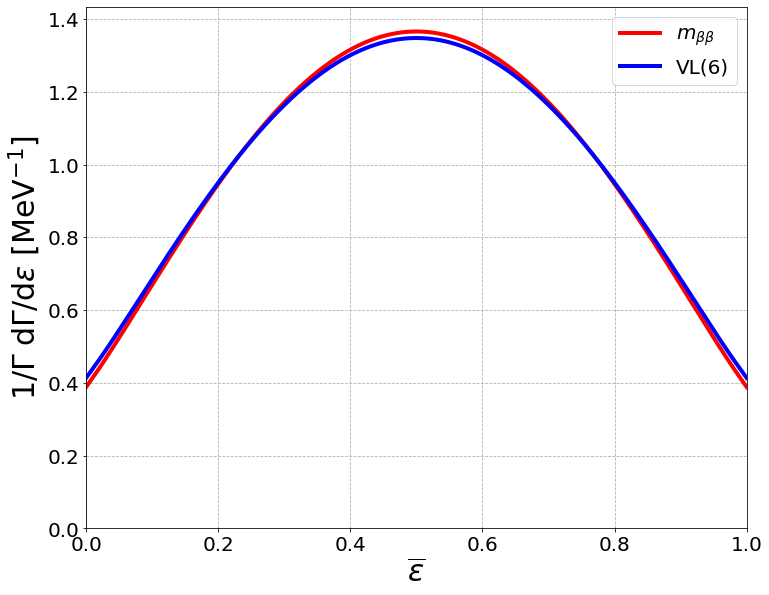

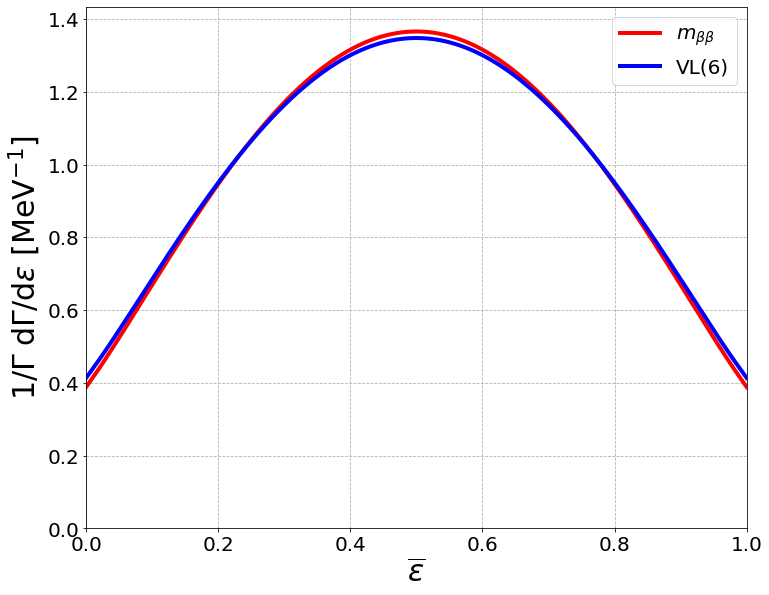

In [5]:
#Make a plot of the spectrum comparing to the standard mechanism
model.plot_spec(isotope="136Xe", linewidth = 4, normalize_x = True, savefig = True,
file = "spec.png")

In [6]:
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [7]:
# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)
#print(p_vec)

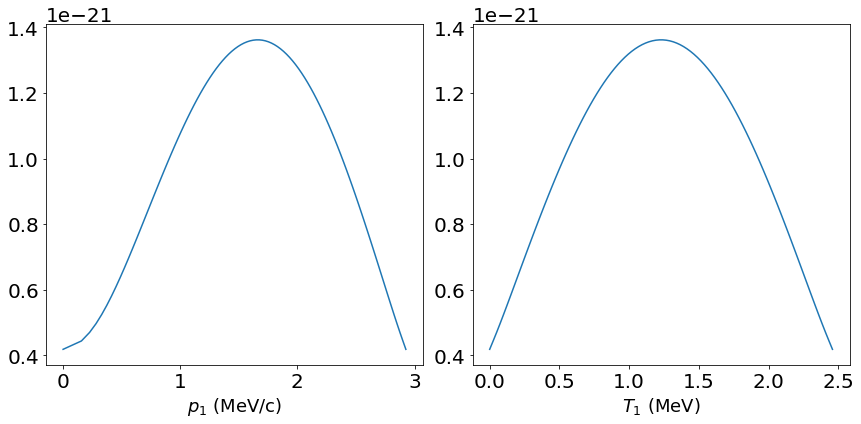

In [8]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
#plt.ylim(0, 5.e-27)
plt.plot(p_vec, rho_spec_vec)
plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)

plt.subplot(122)
#plt.ylim(0, 5.e-27)
plt.plot(t_vec, rho_spec_vec)
plt.xlabel(r'$T_1$ (MeV)', fontsize=18)

plt.tight_layout()

In [9]:
# Find maximum, for random generation along y axis for accept-reject method
rho_spec_max = np.max(rho_spec_vec)
print("rho_spec_max = ", rho_spec_max)

p_max = p_fun(Q)
print(p_max)
t_max = Q
print(t_max)

rho_spec_max =  1.361831659510431e-21
2.9246777310482606
2.457984


In [10]:
rho_spec_fun = interp1d(t_vec, rho_spec_vec, kind='linear', fill_value=(rho_spec_vec[0],rho_spec_vec[-1]), bounds_error=False)

In [11]:
t1_vec = np.zeros(nevts)
t2_vec = np.zeros(nevts)

ievt = 0

while ievt < nevts:

    t1 = np.random.uniform(low = 0., high = t_max)
    p1 = p_fun(t1)
    t2 = Q - t1
    p2 = p_fun(t2)
    
    if (t1 < 0 or t2 < 0 or t1 > t_max or t2 > t_max):
        print(t1,t2)
    
    f = np.random.uniform(low=0., high=rho_spec_max)  
 
    if (f < rho_spec_fun(t1)):
        t1_vec[ievt] = t1 # MeV units
        t2_vec[ievt] = t2 # MeC units
        ievt += 1
        
print("# accepted = ", ievt, " over ", nevts)

# accepted =  100000  over  100000


### Second, sampling of electron angular distributions

In [12]:
#GEt angular correlation
rho_angle_vec = model.angular_corr(ebar_vec, isotope = "136Xe")

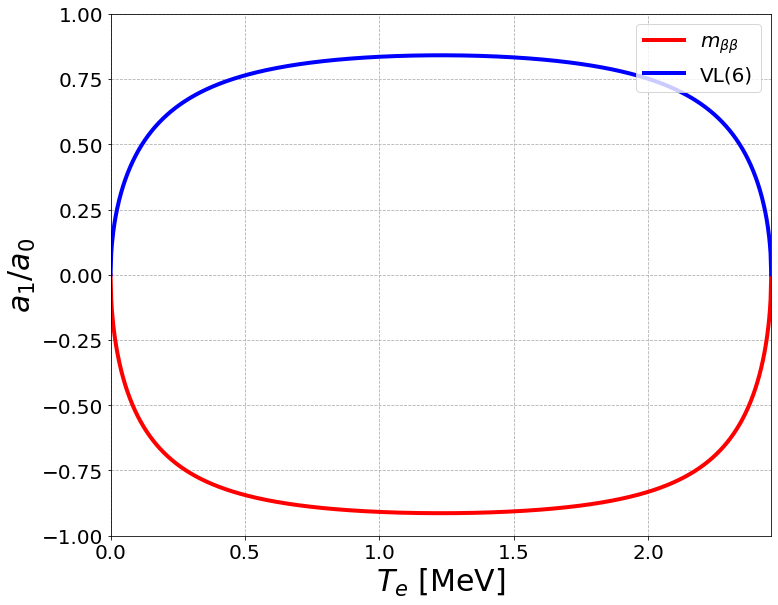

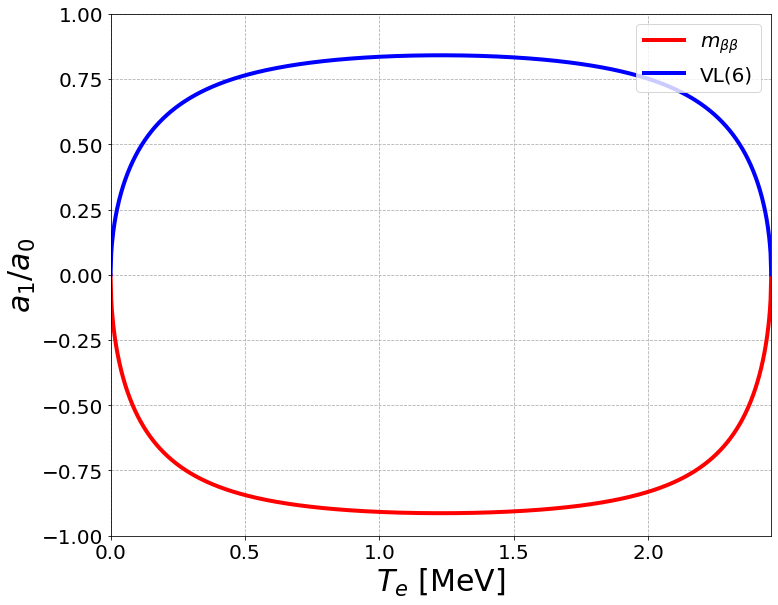

In [13]:
#Make a plot of the angular correlation comparing to the standard mechanism
model.plot_corr(isotope="136Xe", linewidth = 4, normalize_x = False, 
                savefig = True, file = "corr.png")

In [14]:
rho_angle_fun = interp1d(ebar_vec, rho_angle_vec, kind='linear', fill_value=(rho_angle_vec[0],rho_angle_vec[-1]), bounds_error=False)

In [15]:
def cos12_fun(theta1, phi1, theta2, phi2): #cos12 = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    x = np.sin(theta1)*np.cos(phi1) * np.sin(theta2)*np.cos(phi2)
    y = np.sin(theta1)*np.sin(phi1) * np.sin(theta2)*np.sin(phi2)
    z = np.cos(theta1) * np.cos(theta2)
    return x+y+z

In [16]:
def eta_fun(ebar,theta1,phi1,theta2,phi2):
    eta = 1 + rho_angle_fun(ebar)*cos12_fun(theta1,phi1,theta2,phi2)
    return eta

In [17]:
theta1_vec = np.zeros(nevts)
theta2_vec = np.zeros(nevts)
phi1_vec = np.zeros(nevts)
phi2_vec = np.zeros(nevts)

ievt = 0

# Get vector of p1, p2, beta1 and beta2 values
p1_vec = p_fun(t1_vec)
p2_vec = p_fun(t2_vec)


while ievt < nevts:
    
    t1 = t1_vec[ievt]
    ebar = t1/Q
    # eta_max is for costheta=-1 or costheta=+1, depending on the sign of rho_angle_fun
    eta_max = max(1 - rho_angle_fun(ebar), 1 + rho_angle_fun(ebar))
    #print(ebar,eta_max)
    
    # Note: the cosine of polar angles need to be generated uniformly between -1 and +1. 
    costheta1 = np.random.uniform(low = -1., high = +1.)
    theta1 = np.arccos(costheta1)
    phi1 = np.random.uniform(low = 0., high = 2.*np.pi)
    
    costheta2 = np.random.uniform(low = -1., high = +1.)
    theta2 = np.arccos(costheta2)
    phi2 = np.random.uniform(low = 0., high = 2.*np.pi)
    
    f = np.random.uniform(low=0., high=eta_max) 
 
    if (f < eta_fun(ebar,theta1,phi1,theta2,phi2)):
        theta1_vec[ievt] = theta1 
        phi1_vec[ievt] = phi1
        theta2_vec[ievt] = theta2 
        phi2_vec[ievt] = phi2
        ievt += 1
        
print("# accepted = ", ievt, " over ", nevts)


# accepted =  100000  over  100000


### Define the momenta components $p_x, p_y, p_z$ of the electrons 

In [18]:
p1x_vec = np.zeros(nevts)
p1y_vec = np.zeros(nevts)
p1z_vec = np.zeros(nevts)

p2x_vec = np.zeros(nevts)
p2y_vec = np.zeros(nevts)
p2z_vec = np.zeros(nevts)


for ievt in range(nevts):
    p1x_vec[ievt] = p1_vec[ievt]*np.sin(theta1_vec[ievt])*np.cos(phi1_vec[ievt])
    p1y_vec[ievt] = p1_vec[ievt]*np.sin(theta1_vec[ievt])*np.sin(phi1_vec[ievt]) 
    p1z_vec[ievt] = p1_vec[ievt]*np.cos(theta1_vec[ievt])
    
    p2x_vec[ievt] = p2_vec[ievt]*np.sin(theta2_vec[ievt])*np.cos(phi2_vec[ievt])
    p2y_vec[ievt] = p2_vec[ievt]*np.sin(theta2_vec[ievt])*np.sin(phi2_vec[ievt]) 
    p2z_vec[ievt] = p2_vec[ievt]*np.cos(theta2_vec[ievt])

### Save in data file
preparing the output for Geant4

In [19]:
#with open(outfile, "w") as file:
#    file.write("First event and full number of events:\n")
#    file.write("{}  {}\n\n".format(1,nevts))
#    for i in range(nevts):
#        file.write(f"{i}  0.  2\n")
#        file.write("3  {:.5f}  {:.5f}  {:.5f}  {}\n".format(p1x_vec[i], p1y_vec[i], p1z_vec[i], 0.0000))
#        file.write("3  {:.5f}  {:.5f}  {:.5f}  {}\n".format(p2x_vec[i], p2y_vec[i], p2z_vec[i], 0.0000))

### Check the distributions

In [20]:
cos12_vec = cos12_fun(theta1_vec, phi1_vec, theta2_vec, phi2_vec)

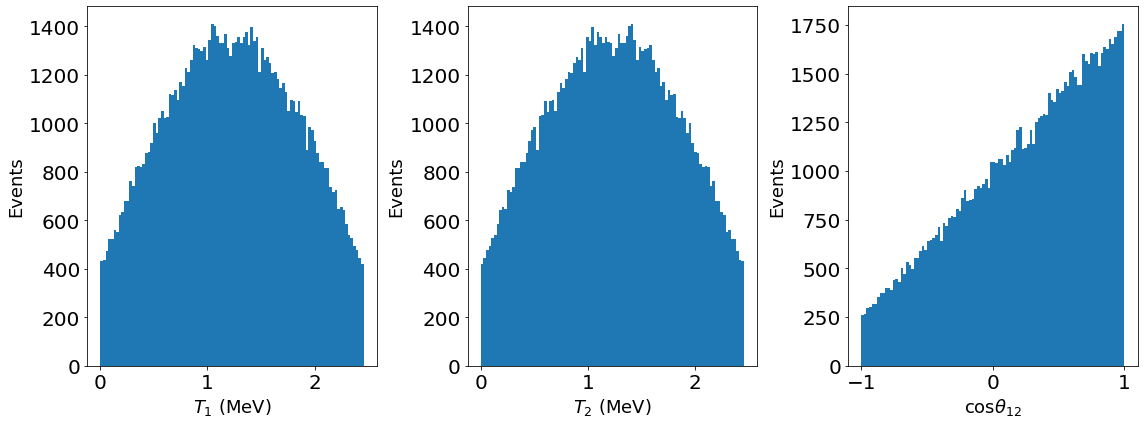

In [21]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(131)
plt.hist(t1_vec, bins=100)
plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
plt.ylabel('Events', fontsize=18)

plt.subplot(132)
plt.hist(t2_vec, bins=100)
plt.xlabel(r'$T_2$ (MeV)', fontsize=18)
plt.ylabel('Events', fontsize=18)

plt.subplot(133)
counts_costheta12, bins_costheta12, patches = plt.hist(cos12_vec, bins=100)
plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

fig.tight_layout()
plt.savefig(imagefile)

### Compute dq2 for $T_1$, and Mean and for $\cos\theta_{12}$

In [22]:
def linear_fit(x,a,b):
    return a * (1 + b*x)

In [23]:
def dq2_fun(t1_vec):
    halfQ = Q/2.
    dq2 = 0
    for i in range(len(t1_vec)):
        dq2 += (t1_vec[i]-halfQ)**2
    dq2 = np.sqrt(dq2/len(t1_vec))
    dq2 = dq2/halfQ
    return dq2

In [24]:
dq2_t1 = dq2_fun(t1_vec)
print('dq2 T1:', round(dq2_t1,3))

mean_cos12 = np.mean(cos12_vec)
print('Mean cos12:', round(mean_cos12,3))

xdata = (bins_costheta12[:-1] + bins_costheta12[1:]) / 2
ydata = counts_costheta12
yerrdata = np.power(counts_costheta12, 1/2)
popt, pcov = curve_fit(linear_fit,xdata,ydata,sigma=yerrdata,p0=(1000.,-0.9),absolute_sigma=True,bounds=([0.,-1],[1.e6,1]))
#print(popt[0],popt[1])
#print(pcov)
#print('Slope cos12:', round(popt[1],3))

x_fine = np.linspace(-1,1,num=200)
y_fine = popt[0]*(1+popt[1]*x_fine)
#print(y_fine)

dq2 T1: 0.496
Mean cos12: 0.253


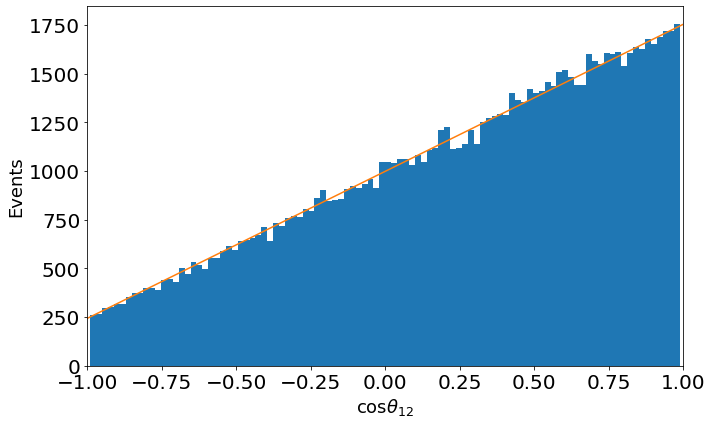

In [25]:
fig = plt.figure(figsize=(10, 6))
plt.hist(xdata,bins=nbins,weights=ydata)
plt.plot(x_fine,y_fine)
plt.xlim(-1.,1.)

plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

fig.tight_layout()


### Table summarizing distribution features of various LEFT models

| Model | dq2 of $T_1$ dist. | Mean of $\cos\theta_{12}$ dist. |
| :-: | :-: | :-: |
| m_bb  | 0.492 | -0.283 |
| SL(6) | 0.492 | -0.283 |
| SR(6) | 0.492 | -0.280 | 
| T(6)  | 0.493 | -0.282 | 
| VL(6) | 0.495 | +0.256 | 
| VR(6) | 0.711 | +0.248 |
| VL(7) | 0.492 | -0.282 | 
| VR(7) | 0.491 | -0.282 | 
| 1L(9) | 0.492 | -0.280 | 
| 1R(9) | 0.492 | -0.279 | 
| 1L(9)prime | 0.493 | -0.282 | 
| 1R(9)prime | 0.492 | -0.279 | 
| 2L(9) | 0.491 | -0.281 | 
| 2R(9) | 0.493 | -0.279 | 
| 2L(9)prime | 0.493 | -0.280 | 
| 2R(9)prime | 0.492 | -0.280 | 
| 3L(9) | 0.493 | -0.279 | 
| 3R(9) | 0.492 | -0.284 | 
| 3L(9)prime | 0.491 | -0.282 | 
| 3R(9)prime | 0.493 | -0.283 | 
| 4L(9) | 0.492 | -0.283 | 
| 4R(9) | 0.491 | -0.280 | 
| 5L(9) | 0.493 | -0.283 | 
| 5R(9) | 0.491 | -0.282 | 
| 6(9) | 0.497 | +0.255 | 
| 6(9)prime | 0.495 | +0.251 | 
| 7(9) | 0.496 | +0.257 | 
| 7(9)prime | 0.496 | +0.252 | 
| 8(9) | 0.496 | +0.255 | 
| 8(9)prime | 0.498 | +0.255 | 
| 9(9) | 0.496 | +0.257 | 
| 9(9)prime | 0.497 | +0.252 | 
